In [1]:
# Read the markdown file
with open('report.md', 'r') as file:
    markdown_content = file.read()

# Display it as markdown
from IPython.display import display, Markdown
display(Markdown(markdown_content))

# Mobile Robots Project: Autonomous Navigation and Control

# Table of Contents
- [Overview](#overview)
  - [Objectives](#objectives)
  - [Hardware](#hardware)
- [Team Members](#team-members)
  - [Role Distribution](#role-distribution)
- [Introduction](#introduction)
  - [Project Demonstration](#project-demonstration)
- [Computer Vision](#computer-vision)
  - [Calibration](#calibration)
    - [Process](#process)
    - [Calibration Parameters](#calibration-parameters)
  - [ArUco Marker Detection](#aruco-marker-detection)
    - [Marker Configuration](#marker-configuration)
  - [Perspective Transform](#perspective-transform)
    - [Computing the Transform Matrix](#computing-the-transform-matrix)
    - [Applying the Transform](#applying-the-transform)
  - [Obstacle Detection](#obstacle-detection)
    - [Processing Pipeline](#processing-pipeline)
    - [Corner Filtering](#corner-filtering)
- [Global Navigation](#global-navigation)
  - [Obstacle processing](#obstacle-processing)
  - [Visibility graph construction](#visibility-graph-construction)
  - [Shortest path computation](#shortest-path-computation)
- [Local Navigation](#local-navigation)
  - [Local Navigation Introduction](#local-navigation-intro)
  - [Control Loop](#control-loop)
  - [Path Following Loop](#path-following-loop)
  - [Obstacle Avoidance Loop](#obstacle-avoidance-loop)
- [Filtering](#filtering)
  - [Extended Kalman Filter Model](#extended-kalman-filter)
    - [Prediction Step](#prediction-step)
    - [Update Step](#update-step)
    - [Noise Covariance Matrices](#noise-covariance-matrices)
- [Motion Control](#motion-control)
- [Conclusion](#conclusion)

## Overview
This project was developed as part of the **Basics of Mobile Robotics (MICRO-452)** course at EPFL, under the supervision of Professor Francesco Mondada from the [MOBOTS Laboratory](https://www.epfl.ch/labs/mobots/).

### Objectives
We aims to develop an autonomous navigation system for the Thymio robot that can:
1. Navigate through a predefined environment with static obstacles using global navigation
2. Dynamically avoid unexpected obstacles using local navigation
3. Maintain accurate position estimation through filtering
4. Reliably reach arbitrary target positions in the environment

### Hardware

| Peripheral            | Model    |
|------------           |----------|
| Robot                 | [Thymio II (MOBSYA)](https://www.thymio.org/) |
| Webcam        | [Aukey Webcam](https://www.aukey.com/) |


## Team Members

Our team consists of four first-year Master's students in Robotics at EPFL:

| Name            | SCIPER  |
|----------------  |---------|
| David Kejik      | 347530  |
| Ines Altemir Mariñas  | 344399 |
| Michel Abela    | 339421  |
| Rayan Gauderon  | 347428  |

### Role Distribution
The project responsibilities are distributed to maximize efficiency while ensuring each team member contributes to multiple aspects of the system:

- **Vision and Environment Processing**: Rayan and Michel
- **Path Planning and Navigation**: Inés and David
- **Robot Control and Localization**: All team members
- **System Integration and Testing**: All team members

## Introduction

Mobile robots that can move on their own are becoming more common in our daily lives, from robots that move boxes in warehouses to those that help at home. One of the main challenges for these robots is finding their way around while avoiding obstacles that might appear in their path.

In this project, we work with the Thymio II robot to create a system that helps it move safely from one point to another. Our solution combines two main ways of navigation: planning a full path ahead of time (using a map), and reacting to new obstacles that weren't there before (when someone puts something in the robot's way).

### Experimental Setup and Design Choices

Our experimental environment consists of a well-defined workspace measuring 120x100 centimeters, providing ample space for navigation while maintaining a controlled testing environment. We implemented several key design choices to create a robust and reliable navigation system:

**Localization System:**
- Utilized ArUco markers for precise positioning
- Markers serve multiple purposes:
  - Defining the map boundaries
  - Marking goal positions
  - Tracking the Thymio robot's current position and orientation

**Test Environment:**
- Modular obstacle system featuring varying sizes (15-30cm)
- Flexible configuration allowing for different testing scenarios
- High-contrast surface to ensure reliable visual detection

**Path Planning Strategy:**
- Implemented a visibility graph approach, optimized for environments with polygonal obstacles

- Key components of the visibility graph algorithm:
  - Creates nodes from robot's starting position, obstacle vertices, and goal position
  - Establishes edges between mutually visible nodes (no obstacle intersections)
  - Applies Dijkstra's algorithm to determine the shortest viable path


**Control Strategy:**
- Developed a proportional control system with dual feedback mechanisms:
  - Dynamically adjusts both linear and angular velocities
  - Maintains smooth transitions between movement phases
  
- Distance-based speed control features:
  - Proportionally reduces linear velocity as robot nears goal
  - Includes safety thresholds for minimum/maximum speeds

- Orientation-based control characteristics:
  - Modulates linear velocity based on angle to target
  - Applies proportional angular velocity corrections
  - Prioritizes orientation alignment before forward movement

### Project Demonstration

Below is a demonstration of our autonomous navigation system in action:

<p align="center">
  <video width="320" height="240" controls>
    <source src="/vids/demo.mp4" type="video/mp4">
  </video>
</p>

In this video, you can see:
- The Thymio robot navigating through our environment
- Real-time path planning and execution
- Dynamic obstacle avoidance in action
- Position tracking with our vision system

## Computer Vision

### Calibration

Camera calibration is a crucial step in our computer vision pipeline, as it helps remove lens distortion and provides essential camera parameters. We implemented our calibration process based on this [OpenCV's guide](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html), using the checkerboard pattern below:

<p align="center">
<img src="img/vision/calibration/checkerboard.png" width="700" alt="checkerboard">
</p>

#### Process

The calibration process involves:
1. Collecting a set of 15 images of a checkerboard pattern from different angles and distances to ensure robust calibration
2. Detecting the inner corners in each image using `cv2.findChessboardCorners()`, followed by corner position refinement to sub-pixel accuracy with `cv2.cornerSubPix()`
3. Using these detections to compute the camera's intrinsic parameters and distortion coefficients with `cv2.calibrateCamera()`

#### Calibration Parameters
The calibration provides two essential outputs:

1. **Camera Matrix**: A 3×3 matrix containing the camera's intrinsic parameters:
   - Focal lengths (fx, fy)
   - Principal point coordinates (cx, cy)
$$
M = 
\left( \begin{matrix}
f_x & 0 & c_x\\
0 & f_y & c_y\\
0 & 0 & 1
\end{matrix} \right)
$$
2. **Distortion Coefficients**: A vector containing the lens distortion parameters:
   - Radial distortion coefficients (k1, k2, k3)
   - Tangential distortion coefficients (p1, p2)
$$
D = 
\left( \begin{matrix} 
k_1 & k_2 & p_1 & p_2 & k_3
\end{matrix}\right)
$$

#### Utilization

Once calibrated, we can undistort any frame from our camera providing a more accurate representation of the scene for subsequent vision processing steps:

```python
def _undistort_frame(self, frame):
    # Get optimal camera matrix to minimize unwanted pixels
    h, w = frame.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(CAM_MATRIX, CAM_DISTORTION, (w, h), 1, (w, h))
    
    # Apply undistortion
    frame = cv2.undistort(frame, CAM_MATRIX, CAM_DISTORTION, None, newcameramtx)
    
    # Crop the frame to remove invalid pixels
    x, y, w, h = roi
    frame = frame[y:y+h, x:x+w]
    return frame
```
### ArUco Marker Detection

Our vision system uses ArUco markers for robust detection and tracking of the robot's position, orientation, and other key elements in the environment. We utilized [OpenCV's Aruco module](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html) with 4x4 markers.

#### Marker Configuration
The system uses different marker IDs for specific purposes:

- IDs 0-3: Corner markers for perspective transformation
- ID 4: Thymio robot position and orientation
- ID 5: Goal position

Here's the initialization of the ArUco detector:

```python
def __init__(self, device_id):
    # Initialize 4x4 ArUco marker detector with 50 unique markers
    self.aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    self.parameters = cv2.aruco.DetectorParameters()
    self.detector = cv2.aruco.ArucoDetector(self.aruco_dict, self.parameters)
```
The detection process uses OpenCV's `detectMarkers()` function, which returns the corners and IDs of all detected markers in the frame.

### Perspective Transform

A perspective transform is implemented  to convert the camera's angled view into a top-down perspective, which is essential for accurate navigation and obstacle detection. We based our implementation on [OpenCV's geometric transformations](https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html). The map used can be find below:

<p align="center">
<img src="img/vision/aruco_markers/map.png" width="700" alt="map environment">
</p>

#### Computing the Transform Matrix

We use the four corner ArUco markers (IDs 0-3) as reference points to compute the perspective transformation matrix. The process involves mapping these source points to destination points that represent a rectangular top-down view:

```python
def _compute_perspective_transform(self, source_points, world_width, world_height):
    # Calculate pixel to millimeter scale factor
    self.scale_factor = CAM_RESOLUTION[1] / world_width
    
    # Calculate dimensions of transformed image
    dest_width = world_width * self.scale_factor 
    dest_height = world_height * self.scale_factor 
    
    # Define destination points for top-down view
    dest_points = np.float32([
        [0, dest_height],          # bottom-left
        [dest_width, dest_height], # bottom-right
        [0, 0],                    # top-left
        [dest_width, 0]            # top-right  
    ])
    
    # Calculate perspective transformation matrix
    self.perspective_matrix = cv2.getPerspectiveTransform(source_points, dest_points)
```

#### Applying the Transform

Once we have the transformation matrix, we can convert any frame to a top-down view using `cv2.warpPerspective`:

```python
def get_frame(self):
    # Capture frame and apply perspective transform
    original_frame = self._get_original_frame()
    process_frame = cv2.warpPerspective(original_frame, 
                                      self.perspective_matrix, 
                                      self.process_roi)  
    return original_frame, process_frame
```

This transformation allows us to:
- Convert camera coordinates to real-world coordinates
- Obtain accurate measurements for robot navigation
- Simplify obstacle detection and path planning algorithms

<p align="center">
<img src="img/vision/obstacles/process.png" width="700" alt="local_nav_ann">
</p>

### Obstacle Detection

Our obstacle detection system combines Canny edge detection and contour finding from OpenCV to identify obstacles in the environment. The implementation is based on [OpenCV's Canny Edge Detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) and [Contour Detection](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html) tutorials. A typical environment with different shape obstacles can be seen below:

<p align="center">
<img src="img/vision/obstacles/environment.png" width="700" alt="obstacles">
</p>

#### Processing Pipeline

The obstacle detection follows a multi-stage image processing pipeline designed to reliably identify obstacles of various shapes and sizes:

**Image Preprocessing**:
First, we prepare the image for edge detection through several preprocessing steps:
```python
# Convert to grayscale and apply Gaussian blur
gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)

# Apply Otsu's thresholding
_, threshold_frame = cv2.threshold(blurred_frame, 0, 255, 
                                 cv2.THRESH_BINARY + cv2.THRESH_OTSU)
```
The Gaussian blur helps reduce noise while preserving edges, and Otsu's thresholding automatically determines the optimal threshold value for binarization.

**Edge Detection**:
We use the Canny edge detector, which is known for its ability to detect true edges while minimizing false detections:
```python
# Apply Canny edge detection
edges_frame = cv2.Canny(threshold_frame, 50, 150)
```
The parameters 50 and 150 represent the lower and upper thresholds for the hysteresis procedure in Canny edge detection.

<p align="center">
<img src="img/vision/obstacles/edges_detection.png" width="700" alt="egdes">
</p>

**Contour Detection and Processing**:
After edge detection, we find and process contours to identify obstacle boundaries:
```python
# Find contours of obstacles
contours, _ = cv2.findContours(edges_frame, 
                              cv2.RETR_EXTERNAL, 
                              cv2.CHAIN_APPROX_SIMPLE)

# Process each contour above minimum area threshold
for contour in contours:
    if cv2.contourArea(contour) <= OBSTACLE_MIN_AREA:
        continue
        
    # Approximate contour with polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2).astype(np.float32)
```
We use `cv2.RETR_EXTERNAL` to only retrieve the outer contours, and `cv2.CHAIN_APPROX_SIMPLE` to compress horizontal, vertical, and diagonal segments and leave only their end points. The `OBSTACLE_MIN_AREA` threshold helps filter out small noise contours.

<p align="center">
<img src="img/vision/obstacles/contours_detection.png" width="700" alt="contours">
</p>

#### Corner Filtering

To ensure accurate obstacle representation while minimizing computational complexity, we implement a corner filtering mechanism that removes redundant points:

```python
def _filter_close_corners(self, corners, min_distance=10):
    # Return empty list if no corners
    if len(corners) == 0:
        return corners
    
    corners = np.array(corners)
    filtered_corners = [corners[0]]
    
    # Keep corners that are at least min_distance away from all kept corners
    for corner in corners[1:]:
        if all(utils.distance(corner, kept_corner) >= min_distance 
               for kept_corner in filtered_corners):
            filtered_corners.append(corner)
    
    return np.array(filtered_corners)
```

This filtering process:
- Starts with the first corner point
- Adds subsequent corners only if they are at least `min_distance` pixels away from all previously kept corners
- Helps create a more efficient representation of obstacles while maintaining their shape accuracy

Finally, the detected obstacle corners are converted from pixel coordinates to millimeters using our perspective transform scale factor. This conversion is crucial for the navigation system as it needs real-world measurements to plan paths and avoid obstacles effectively.


### Keys Features
The combination of these processing steps creates a robust obstacle detection system that:

✓ Works reliably under varying lighting conditions \
✓ Handles obstacles of different shapes and sizes \
✓ Provides accurate position information in real-world coordinates \
✓ Minimizes false detections through filtering

### Future Improvements
The current vision system could be improve to handle more realistic scenarios by:

* Replacing binary color detection (black/white) with object detection ML models like [YOLOv8](https://yolov8.com/) to support varied colors, more complex shapes and textures
* Removing ArUco marker dependency by implementing [Visual SLAM](https://cvg.cit.tum.de/research/vslam)


## Global navigation
The aim of global navigation is to find a collision-free path from the start position to the goal position. To this end, we must gather a global map of the environment, a start and goal position (obtained from the camera at the beginning) , a path planning algorithm (Djikstra's algorithm in our case) and a path following module. 

Furthermore, optimality can be defined with respect to different criteria, such as length, execution time, energy consumption and more. In our case, the visibility graph and Djikstra's algorithm allow us to find the shortest path (length) from the start node to the end node, in the context of road-map graphs.

This function is fulfilled by the Global Navigation module. The full code is found in the global_navigation.py file.

The global navigation module employs a visibility graph approach for optimal path planning, enabling the Thymio robot to navigate efficiently around static obstacles. The implementation is based on the [PyVisGraph library](https://github.com/TaipanRex/pyvisgraph) which efficiently constructs visibility graphs from detected polygonal obstacles. This library was chosen for its ease of use. The module interfaces directly with our [vision based](#computer-vision) obstacle detection system to maintain an accurate environmental model.


1. Image of map, with obstacles, start, end !!!


The path planning process consists of three main components:
1. Obstacle processing with safety margins
2. Visibility graph construction
3. Shortest path computation

These components are integrated in the `get_trajectory()` function, which executes the complete planning pipeline.

### Obstacle Processing

Before constructing the visibility graph, we use the `extend_obstacles()` function to extend all obstacles by a safety margin (found empirically), ensuring that the robot maintains a safe obstacles distance during navigation:

```python
def _extend_obstacles(self, corners, thymio_width):
    # Calculate obstacle centroid
    center = np.mean(corners, axis=0)
    extended_corners = np.zeros_like(corners)
    
    # Extend each corner outward from center
    for i in range(len(corners)):
        vector = corners[i] - center
        length = np.linalg.norm(vector)
        
        if length > 0:
            # Normalize and scale vector by robot width plus margin
            normalized_vector = vector / length
            extended_corners[i] = corners[i] + normalized_vector * (thymio_width//2 + SECURITY_MARGIN) 
            
    return extended_corners
```

The obstacle extension process:
- Calculates the centroid of each obstacle
- Extends each corner outward from the centroid
- Adds `SECURITY_MARGIN` plus half the robot's width
- Ensures safe clearance during navigation

<p align="center">
<img src="img/global_nav/extended_obstacles.png" width="700" alt="extended obstacles">
</p>

In conclusion, before handing these obstacles to the Visibility Graph `build()` method, we must perform an a priori expansion of obstacles, taking into account the geometry of the Thymio Robot and a security margin, for our algorithm to be implemented robustly. The `SECURITY_MARGIN` value has been empirically proven to be sufficient to not graze obstacles. This additional step is necessary due to the fact the Visibility Graph makes the assumption of a mass-less, holonomic, pointlike robot.
The `SECURITY_MARGIN` also accounts for the uncertainty in the robot's position covariance as well as the detection of obstacles (done through camera vision).  

### Visibility Graph
For the task of graph creation, to capture the connectivity of the free space into a graph that is subsequently searched for paths, we used the road-map approach of Visibility Graphs. We utilize the [Pyvisgraph library](https://github.com/TaipanRex/pyvisgraph), which given a set of simple obstacle polygons, builds a visibility graph. We have chosen Visibility Graphs as they are well documented, well known, provide a complete solution and more that make it stand out in comparison to other methods such as Voronoi diagrams or adaptive-cell decomposition.

#### Visibility Graph Construction

The visibility graph is constructed in the `compute_trajectory()` function using the following steps :

1. **Point Conversion**: Convert robot position, goal position, and obstacle corners to visibility graph points:
```python
# Create pyvisgraph points for start and goal
start = vg.Point(thymio_pos[0], thymio_pos[1])
end = vg.Point(goal_pos[0], goal_pos[1])

# Convert obstacles to pyvisgraph format
polygon_obstacles = []
for obstacle in obstacles:
    polygon = []
    for point in obstacle:
        polygon.append(vg.Point(point[0], point[1]))
    polygon_obstacles.append(polygon)
```

2. **Graph Building**: Create edges between visible vertices:
```python
# Create visibility graph and find shortest path
graph = vg.VisGraph()
graph.build(polygon_obstacles, status=False)
```

The way `build()` creates the graph is by identifying all vertices (including start and goal positions), and then connecting pairs of vertices with edges if the straight line between them doesn't intersect any polygon obstacles.

### Path Planning 
Once the visibility graph is constructed, we compute the shortest path using [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) implemented in the PyVisGraph's `shortest_path()`function. This approach guarantees finding the shortest geometric path between start and goal. 

```python
shortest_path = graph.shortest_path(start, end)

# Calculate total path length
path_length = 0
for i in range(len(shortest_path) - 1):
    p1, p2 = shortest_path[i], shortest_path[i + 1]
    path_length += ((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2) ** 0.5
```

The path computation:
- Finds the shortest sequence of edges connecting start to goal
- Calculates the total path length 
- Returns a series of waypoints for the robot to follow

<p align="center">
<img src="img/global_nav/trajectory.png" width="700" alt="extended obstacles">
</p>

Finally, the `get_trajectory()` function combines everything and handles the visualization.

This navigation algorithm is computationally efficient enough to enable real-time computation, allowing for immediate path recalculation in scenarios like local avoidance or kidnapping.

#### Key Features

Our global navigation implementation provides several important capabilities:

✓ Shortest path planning through visibility graph approach \
✓ Automatic safety margin calculation based on robot size \
✓ Path computation and visualization \
✓ Integration with vision system coordinates \
✓ Support for arbitrary polygon obstacle shapes and positions

The complete implementation pipeline is detailed below:

<p align="center">
<img src="img/global_nav/global_nav_map.svg" width="700" alt="extended obstacles">
</p>


#### Considerations  
- Our implementation of global navigation does not account for dynamic obstacles, as we intentionally avoid using camera vision to update obstacles when new ones are detected. This approach is designed to test and challenge the local navigation system, which is capable of reacting to unexpected and unknown obstacles. If the path becomes blocked, we handle recovery by recomputing a new global path, after performing local obstacle avoidance. 
  
- The potential issues arising from treating the robot as a point, in terms of robot kinematics and dynamics, are taken care of in the Local Navigation module, where we establish a `MAX_ROTATION_SPEED`, a `MIN_TRANSLATION_SPEED`, a `MAX_TRANSLATION_SPEED` and much more. ???

#### Future Improvements
- The Visibility Graph does not account for map boundaries. As a result, if an obstacle is close to the map's edge, the graph may generate a path that goes outside the map to reach the goal, even if there isn’t enough space for the robot to pass between the obstacle and the boundary. This occurs because the `shortest_path()` computation imposes no constraints to ensure the path remains within the map's defined area. When attempting to enforce such constraints, we observed that the extended corner of an obstacle near the map boundary may fall outside the map. This causes the entire obstacle to be invalidated and treated as nonexistent, leading the graph to incorrectly assume there is no obstacle and to generate a path that crosses directly over it. This limitation in our implementation highlights an opportunity for improvement, as designing a custom visibility graph algorithm could better handle such edge cases.

- The requirements of this project do not allow repositioning of obstacles during the experiment. If this were a requirement, dynamic obstacle handling capability to update paths based on newly detected obstacles from the vision system should be added.
 
- The worst-case complexity is at least O(n²log n) for constructing the [Visibility Graph]([https://github.com/TaipanRex/pyvisgraph](https://github.com/TaipanRex/pyvisgraph/tree/master)), where n is the number of vertices. This arises in scenarios where all vertices are mutually visible, requiring visibility checks for every pair of vertices. While this complexity is manageable in static environments with relatively few obstacles, it becomes prohibitively high in dense or highly complex environments with many obstacles, where the number of vertices and potential edges can grow rapidly. Such situations can lead to significant computational overhead, making the approach impractical for real-time applications. Alternatives like Rapidly-exploring Random Trees ([RRTs](https://theclassytim.medium.com/robotic-path-planning-rrt-and-rrt-212319121378)), Potential Fields, and Grid-based methods (e.g., A*, D*,[Grid-based methods](https://www.sciencedirect.com/science/article/pii/S1474667016327410)) offer more scalable solutions, improving in some cases computational efficiency O(nlog n), each with trade-offs in efficiency and path quality.

## Local Navigation

Our local navigation system combines trajectory following with reactive obstacle avoidance, allowing the Thymio robot to follow planned paths while safely handling unexpected obstacles. The implementation uses a proportional control approach for path following and a weighted sensor-based method for obstacle avoidance.

### Control Architecture

The local navigation system operates with three main control loops:

1. Path Following Loop: Executes the planned trajectory
2. Obstacle Avoidance Loop: Handles unexpected obstacles
3. Recovery Loop: Manages transition between obstacle avoidance and path following

The system continuously monitors the robot's position and proximity sensors to determine which control loop should be active.

### Path Following Loop

The path following implementation uses a proportional control approach with separate handling of rotation and translation:

```python
def _calculate_motion_commands(self, angle_diff, distance):
    # Calculate rotation speed proportional to angle error
    if abs(angle_diff) < np.deg2rad(ANGLE_TOLERANCE):
        rotation_speed = 0
    else: 
        rotation_speed = np.clip(KP_ROTATION*angle_diff, 
                               -MAX_ROTATION_SPEED, 
                               MAX_ROTATION_SPEED)
    
    # Forward speed varies with angle error and distance
    angle_factor = np.cos(angle_diff) 
    distance_factor = np.clip(KP_TRANSLATION*distance, 
                            MIN_TRANSLATION_SPEED, 
                            MAX_TRANSLATION_SPEED)
    
    forward_speed = distance_factor * max(0, angle_factor)
    return int(forward_speed), int(rotation_speed)
```

Key features of the path following control:

1. **Angular Control**:
   - Uses proportional control with gain `KP_ROTATION`
   - Implements deadband of ±5° to prevent oscillation
   - Speed limited to `MAX_ROTATION_SPEED`

2. **Linear Control**:
   - Forward speed proportional to distance with gain `KP_TRANSLATION`
   - Speed reduced based on angular error using cosine factor 
   - Bounded between `MIN_TRANSLATION_SPEED` and `MAX_TRANSLATION_SPEED`

### Obstacle Avoidance Loop

When obstacles are detected by the proximity sensors, the system switches to a reactive avoidance behavior:

```python
def _avoid_obstacles(self, sensor_data):
    # Initialize speeds with base obstacle avoidance speed
    left_speed = OBSTACLES_SPEED
    right_speed = OBSTACLES_SPEED

    # Updates speed based on sensor data and weights
    for i in range(len(sensor_data)):
        left_speed += sensor_data[i] * WEIGHT_LEFT[i] / SCALE_SENSOR
        right_speed += sensor_data[i] * WEIGHT_RIGHT[i] / SCALE_SENSOR
```

The obstacle avoidance system features:

1. **Sensor Processing**:
   - Uses 5 front proximity sensors
   - Readings scaled by `SCALE_SENSOR` factor
   - Weights optimized for smooth avoidance behavior

2. **Motor Control**:
   - Asymmetric weight matrices for left/right motors:
     ```python
     WEIGHT_LEFT = [ 5,  8, -10,  -8, -5]  # Positive weights favor right turn
     WEIGHT_RIGHT = [-5, -8, -10, 8,  5]   # Positive weights favor left turn
     ```
   - Base speed of 100 units modified by weighted sensor readings

<p align="center">
<img src="img/local_nav/ANN_robot_control.png" width="400" alt="local_nav_ann">
</p>

### Recovery Behavior

The system implements a recovery mechanism to smoothly transition between obstacle avoidance and path following:

```python
if self._detect_obstacles(sensor_data):
    # Activate obstacle avoidance behavior
    self.obstacles_iter = OBSTACLES_MAX_ITER
    self.needs_recompute = True
    command, goal_reached = self._avoid_obstacles(sensor_data) 
else:
    # Decrement obstacle avoidance counter
    self.obstacles_iter = max(self.obstacles_iter - 1, 0)
    
    if self.obstacles_iter == 0:
        if self.needs_recompute:
            # Request new trajectory from current position
            command = {
                'action': 'recompute_trajectory',
                'current_pos': self.thymio_pos.tolist(),
                'current_orientation': self.thymio_orientation
            }
```

Key aspects of the recovery behavior:

1. **Persistence**:
   - Maintains obstacle avoidance for `OBSTACLES_MAX_ITER` iterations
   - Prevents premature switching between behaviors

2. **Path Recomputation**:
   - Triggers global path replanning after obstacle clearance
   - Uses current position as new start point
   - Maintains original goal position

### Performance Characteristics

The local navigation system achieves several important performance metrics:

✓ Smooth trajectory following with < 5° orientation error \
✓ Reliable obstacle detection and avoidance \
✓ Stable transition between control modes \
✓ Recovery from obstacle encounters with path recomputation


<p align="center">
<img src="img/local_nav/local_nav_map.svg" width="700" alt="local_nav_mindmap">
</p>

### Future Imporovements

- The environment, in which the Thymio robot is moving, is quite predictable, as in not very slippery and despite the little motor speed corrections we apply in this module. In a more slippery or rough terrain (like running on water or moving on a carpet), it could be a good idea to implement a PID controller instead of the simple P controller that we have here... it would ensure more precise movements and pose estimation.
- For the obstacle avoidance loop, a possible improvement could be to use better time of flight (TOF) sensors instead of the infrared proximity sensors, that would allow the Thymio robot to detect local obstacles from further away, and thus plan corrections ahead.

## Filtering
The motivation behind filtering is the fact that we seek to represent a world which is perceived with errors, on which we do actions that do not correspond exactly to our orders, and with maps that are uncertain. To this end, we aim to improve the estimation of our state X, after having incorporated sensor data.

The filtering module's core purpose is robust state estimation for robot localization by fusing multiple data sources, both the computer vision positioning data and the wheel odometry obtained from the Thymio. 

Furthermore, it possesses a fallback capability, as it maintains accurate tracking of the robot's pose and velocities using odometry when vision data is unavailable/unreliable, be it because the camera is covered or because the computer vision submodule is malfunctioning. 

It performs the state estimation of the differential-drive robot, tracking robot pose (x, y, θ) and linear and angular velocity (v, w). We employ a simplified discrete time state space model, assuming a sufficiently small timestep. The state transition equations are:

$$ \begin{align*} 
x_{i+1} &= x_i + v_i \cdot \Delta t \cdot \cos(\theta_i) \\ 
y{i+1} &= y_i + v_i \cdot \Delta t \cdot \cos(\theta_i)\\ 
\theta{i+1} &= \theta_i + \omega_i \cdot \Delta t \\
v{i+1} &= v_i \\
\omega_{i+1} &= \omega_i 
\end{align*} $$

where $\Delta t$ is the time step between updates.

We have chosen the Extended Kalman Filter (EKF) model because it's well documented, well known and compared to other methods such as the Particle Filter, it is less computationally expensive.
The selection of the EKF over the standard Kalman Filter is due to the nonlinearity of the model with respect to the orientation of the robot. The standard Kalman Filter formulation is not sufficient for such cases.

The EKF implementation handles this by processing measurements from both sensors, weighting data based on sensor uncertainty, linearizing the nonlinear motion model around current state estimates, and providing filtered state estimates robust to sensor failures.

### Extended Kalman Filter Model
We are using the following model for extended Kalman filter implementation:
$$ \begin{align*}
x_k = f(x_{k-1}, u_{k-1}) + w_{k-1}
\end{align*}$$

where $$x_k$$ is the state vector at time $$k$$, $$u_{k-1}$$ is the control input, $$f$$ is the nonlinear state transition function, and $$w_{k-1}$$ is the process noise, assumed Gaussian with zero mean and covariance matrix $$Q_{k-1}$$. 

$$ \begin{align*}
z_k = h(x_k) + v_k
\end{align*}$$

where $$z_k$$ is the observation vector, $$h$$ is the observation function and $$v_k$$ is the measurement noise, assumed Gaussian with zero mean and covariance matrix $$R_k$$.


The filter maintains a state vector containing the robot's position (x, y), orientation (θ), and velocities (v, ω):

$$
x = \begin{bmatrix} x & y & \theta & v & \omega \end{bmatrix}^T
$$

This specific choice of the state vector allows us to simplify to the maximum extent possible our observation model, since are our measurements correspond exactly to the state vector. This choice is intuitive and easy-to-use for navigation and motion control. The trade-off is that we must convert between wheel velocities ($$v_{left}$$ and $$v_{right}$$) and robot velocities ($$v$$ and $$\omega$$).

We assume a system described by a nonlinear model. This nonlinear state transition function $$f$$ is: 

**State Transition Model**

$$
\begin{align*}
x_{\text{next}} &= x + v \cdot \cos(\theta) \cdot \Delta t \\
y_{\text{next}} &= y + v \cdot \sin(\theta) \cdot \Delta t \\
\theta_{\text{next}} &= \theta + \omega \cdot \Delta t \\
v_{\text{next}} &= v \\
\omega_{\text{next}} &= \omega
\end{align*}
$$

Furthermore, the state transition matrix $$F$$ can be found by calculating the Jacobian of the nonlinear state transition model $$f$$ with respect to the state $$x$$. This Jacobian is used for computing the covariance propagation on the predicted state. 

$$
F = \begin{bmatrix} 
1 & 0 & -v\sin(\theta)\Delta t & \cos(\theta)\Delta t & 0 \\
0 & 1 & v\cos(\theta)\Delta t & \sin(\theta)\Delta t & 0 \\
0 & 0 & 1 & 0 & \Delta t \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

The state transition is implemented in the `predict()` function, which will be explicited in the Prediction Step part.
        
**Observation Model**
Our measurement function $$h$$ is:

$$\begin{align*}
h(x_i) = \begin{bmatrix} 
x_{\textrm{camera}}\\
y_{\textrm{camera}}\\ 
\theta_{\textrm{camera}}\\ 
v{\textrm{sensor}}\\ 
\omega{\textrm{sensor}} 
\end{bmatrix} 
\end{align*} $$

and the measurement Jacobian $$H$$ is simply the 5x5 identity matrix.

#### Prediction Step
The prediction step uses the differential drive model to estimate the robot's next state. The wheel velocities serve as control inputs. 
We predict the state at time $$k$$:

$$ \begin{align*}
x_k = f(x_{k-1}, u_{k-1})
\end{align*}$$


$$ \begin{align*}
P_k = F_k P_{k-1} F_k^T + Q_k
\end{align*}$$

and compute the predicted covariance $$P_k$$ of the state estimate. 

This Prediction step is done in the `predict()` function. 

```python
def predict(self, u):
    # Extract current state
    x, y, theta, _, _ = self.state
    v_l, v_r = u
    
    # Compute robot velocities from wheel speeds
    v = (v_l + v_r) / 2  # Linear velocity
    omega = (v_l - v_r) / self.wheel_base  # Angular velocity
    
    # Predict next state using nonlinear motion model
    x_next = x + v * np.cos(theta) * self.dt
    y_next = y + v * np.sin(theta) * self.dt
    theta_next = theta + omega * self.dt
    v_next = v
    omega_next = omega

    self.state = np.array([x_next, y_next, theta_next, v_next, omega_next])
        
    # Compute Jacobian of state transition
    F = np.eye(self.n)
    F[0, 2] = -v * np.sin(theta) * self.dt
    F[0, 3] = np.cos(theta) * self.dt
    F[1, 2] = v * np.cos(theta) * self.dt
    F[1, 3] = np.sin(theta) * self.dt
    F[2, 4] = self.dt
    
    # Update covariance
    self.P = F @ self.P @ F.T + self.Q
```

#### Update Step
While our system uses an Extended Kalman Filter due to the nonlinear motion model in the prediction step, our measurement model is actually linear. This is because our vision system and wheel encoders directly observe the state variables without any nonlinear transformations:

Our measurement model is linear because:
1. The vision system directly measures position and orientation (x, y, θ)
2. The wheel encoders, after conversion via `_compute_velocity()`, directly provide robot velocities (v, ω)

Therefore, our measurement equation simplifies to:
$$z_k = Hx_k + v_k, \quad v_k \sim \mathcal{N}(0, R_k)$$
where:
- $H = I$ 
- $z_k = [x, y, \theta, v, \omega]^T$ (direct measurements)
- $x_k = [x, y, \theta, v, \omega]^T$ (state vector)
- $v_k$ is the measurement noise, assumed to be zero mean and with covariance $R_k$
  
The update equations are:

1. **Innovation (Measurement Residual)**:
   $$y_k = z_k - Hx_{k|k-1}$$

2. **Innovation Covariance**:
   $$S_k = HP_{k|k-1}H^T + R_k$$

3. **Kalman Gain**:
   $$K_k = P_{k|k-1}H^TS_k^{-1}$$

4. **State Update**:
   $$x_{k|k} = x_{k|k-1} + K_ky_k$$
   $$P_{k|k} = (I - K_kH)P_{k|k-1}$$

This is a special case of the EKF where:
- The prediction step requires linearization due to nonlinear motion dynamics
- The update step simplifies to standard Kalman filter equations due to linear measurements

This hybrid approach maintains the EKF's ability to handle nonlinear motion while benefiting from the computational simplicity of linear measurements.

We implement this in the `update()` function:
```python
    # Convert wheel velocities to robot velocities
    measurement[3], measurement[4] = self._compute_velocity(measurement[3], measurement[4])
    
    # Linear measurement model - direct observation of states
    H = np.eye(self.n)  # Identity matrix because measurements directly correspond to states
    
    # Compute Kalman gain and update state
    S = H @ self.P @ H.T + self.R
    K = self.P @ H.T @ np.linalg.inv(S)
    
    # Calculate measurement residual
    y = measurement - self.state
    
    # Normalize angle difference to [-π, π]
    y[2] = np.arctan2(np.sin(y[2]), np.cos(y[2]))

    # Update state estimate and covariance
    self.state = self.state + K @ y
    self.P = (np.eye(self.n) - K @ H) @ self.P
```

#### Noise Covariance Matrices
The filter's performance is tuned through two key noise covariance matrices: the process noise covariance $$Q$$ and measurement noise covariance $$R$$ matrices. Both the process and observation noises are assumed to be zero mean multivariate Gaussian noises.
We have performed experiments in the aim of obtaining these values.
Such set-up and results are found in the run_test.ipynb notebook. 

In this notebook, we first perform a speed conversion test, which allows us to determine the value of SPEED_TO_MM_S = 2.9466 (?? CHANGE)

##### Camera Noise Covariance Test 
To represent the measurement error on $$(x,y,\theta)$$. For this task, we collect a sample of 500 camera photographs of a given map configuration, obstacle selection and robot position. Using our Vision module to obtain the Thymio position and orientation from such a frame, we then compute the Camera Measurement Covariance on $$(x,y,\theta)$$.

##### Odometry Noise Covariance Test
The odometry measurement noise on the linear velocity $$v$$  is established by performing 5 trials at 6 selected target values of the speed. The targed_speeds are communicated to the Thymio as a control input `set_motor_speed(target_v, target_v)`, having the left and right velocity equal to the target velocity. Finally, we collect the Thymio's odometry values with: `get_motor_speed()`. We therefore obtain the error distribution on $$v$$ at different target speeds. 
A similar approach is followed to compute the measurement noise on the angular velocity $$\omega$$. This also forms part of the odometry measurement error. 

**Measurement Noise (R)**: Adapts based on camera visibility:
   ```python
   # Camera visible - normal measurement uncertainty
   R_UNCOVERED = np.diag([0.11758080, 0.11758080, 0.00002872, 
                         35.8960, 154.1675])
   
   # Camera occluded - high position/orientation uncertainty
   R_COVERED = np.diag([9999999, 9999999, 9999999, 
                       35.8960, 154.1675])
   ```
 

Due to the fact that the camera vision can be covered, we define two different measurement noise covariance matrices $$R$$, more precisely $$R_{covered}$$ and $$R_{uncovered}$$. When the camera is covered, and therefore camera measurements aren't available, the measurement noise covariance for position and orientation increases significantly, causing the filter to rely more heavily on wheel odometry. This effectively tells the Kalman filter to ignore any position/orientation measurements during these periods and rely solely on the motion model prediction and odometry measurements. This is a common technique in Kalman filtering when certain sensors become temporarily unavailable - setting their corresponding measurement uncertainties to very high values effectively disables their influence on the state estimate.

There is a method in the extended_kalman_filter.py file to detect this covering of the camera and set the measurement noise covariance matrix to the corresponding value:

```python
def set_mode(self, covered):
        if covered:
            self.R = R_COVERED # No measurement from camera
        else:
            self.R = R_UNCOVERED # Measurement from camera
  ```
##### Process Noise Covariance Test
For the process noise covariance matrix $$Q$$, we conduct two tests: one for the process noise on position $$(x, y)$$ and linear velocity $$v$$, and another for the process noise on orientation $$\theta$$ and angular velocity $$\omega$$. Since we have already computed and verified that the camera measurement noise is very low, we will treat the computer vision measurements as equivalent to the ground truth for the purpose of these tests. 

The $$(x,y,v)$$ process noise covariance test is done in the following manner. We have a selection of target speeds, and for each value we do 5 trials. At each target speed, we set the motor speed to that target, let the robot move for a certain time duration, collect the actual_position of the robot at different timestamps through the camera vision, and analytically compute the expected_position of the robot at different timestamps using the state transition model detailed previously. With these two values, we can compute the process variance on $$(x,y,v)$$. 
Finally, for the orientation $$\theta$$ and angular velocity $$\omega$$ process noise covariance, we perform a similar test. Having a selection of target speeds, running multiple trials at each value, having a timespan during which we use the camera vision to collect actual_angles, and using the state transition model to compute expected_angle, and using the comparison of these two values to compute the process noise covariance on $$\theta$$ and $$\omega$$. 
            
 **Process Noise (Q)**: Models uncertainty in the motion model:
   ```python
   Q = np.diag([79.0045, 79.0045, 0.0554, 0.01, 0.01])
   ```
   The larger values for position states reflect greater uncertainty in motion prediction.
   
#### Key Features

Our EKF implementation provides several important capabilities:

✓ Fusion of visual and odometric measurements \
✓ Robust state estimation  \
✓ Smooth trajectory estimation for control

#### Future Improvements
- EKF works well with motion models with mild non-linearities, and uncertainties are roughly Gaussian with zero mean. It can fail when systems are highly non-linear or have multi-modal distributions. In such cases, a [Particle Filter](https://en.wikipedia.org/wiki/Particle_filter) assumes the state-space model can be nonlinear and the initial state and noise distributions can take any form required. This allows it to better handle multi-modal distributions and severe non-linearities.
- Implement adaptive noise covariance matrices (Q and R).Dynamically adjust process and measurement noise based on robot's speed, as higher speeds may need larger process noise
- Add acceleration states to improve motion prediction
- To improve our robustness, we may implement outlier detection by implement Chi-square testing for measurement validation, developing adaptive thresholds for measurement acceptance, and including measurement history analysis for anomaly detection.

## Motion Control

The motion control system integrates all our implemented modules to effectively guide the Thymio robot:

1. The **Vision System** (🩷) and **Odometry** provide input to the **Extended Kalman Filter**(💜) for accurate state estimation
2. **Global Navigation** (🩵) uses the filtered state to plan optimal paths around known obstacles
3. **Local Navigation** (💙) combines the planned path with real-time sensor data to avoid unexpected obstacles
4. The **Controller** converts navigation commands into appropriate motor speeds for the Thymio robot

This integrated approach allows for robust autonomous navigation while handling both static and dynamic obstacles in the environment.

<p align="center">
<img src="img/motion_control/motion_control.svg" width="700" alt="motion_control">
</p>

## Conclusion



# Code Implementation

## Install Required Dependencies

In [1]:
!pip install -r requirements.txt

  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)


## Import Libraries

In [1]:
# External imports
import numpy as np
import time
import tdmclient.notebook

# Internal imports
from scripts.vision import Vision
from scripts.global_navigation import GlobalNav
from scripts.local_navigation import LocalNav
from scripts.extended_kalman_filter import ExtendedKalmanFilter
from utils import utils

## General Configuration

In [2]:
# Time step configuration
DT = 0.1  # s

# Webcam configuration
DEVICE_ID = 2

# World configuration
WORLD_WIDTH = 1300  # mm
WORLD_HEIGHT = 900 # mm
WORLD_MAP = np.array([WORLD_WIDTH, WORLD_HEIGHT])

# Thymio configuration
THYMIO_WIDTH = 110  # mm
THYMIO_LENGTH = 110  # mm$
THYMIO_WHEEL_BASE = 90  # mm
THYMIO_WHEEL_RADIUS = 20  # mm
SPEED_TO_MM_S = 3.5218/2 # Found experimentally (cf run_tests.ipynb)

# Kidnapping configuration
KIDNAP_THRESHOLD = 60 # mm

## Initialize Classes

In [3]:
vision = Vision(DEVICE_ID)
global_nav = GlobalNav()
local_nav = LocalNav()
ekf = ExtendedKalmanFilter(DT, THYMIO_WHEEL_BASE)

Vision initialized correctly.
GlobalNav initialized correctly.
LocalNav initialized correctly.
EKF initialized correctly.


## Connect to Thymio

In [5]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


## Define Thymio Functions

In [6]:
@tdmclient.notebook.sync_var
def set_speed(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def get_speed():
    global motor_left_speed, motor_right_speed
    return motor_left_speed, motor_right_speed
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


## Test Thymio Functions

In [7]:
set_speed(100, 100)
time.sleep(1)
v_l, v_r = get_speed()
print(f"Current speeds: {v_l}, {v_r}")
motor_stop()

Current speeds: 101, 95


## Test Camera

In [8]:
try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    start_time = time.time()
    while time.time() - start_time < 3:
        original_frame = vision._get_original_frame()
        utils.display_frames(original_frame, None, None)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam disconnected correctly.


## Motion Control

### System Initialization

* Get perspective view, obstacles, thymio and goal positions
* Plan the trajectory
* Initialize EKF parameters 

Webcam disconnected correctly.

=== Obstacles Information ===
Number of obstacles detected: 5
Obstacle coordinates [mm]:

Obstacle 1:
    Corner 1: [1125.5, 579.0]
    Corner 2: [940.1, 587.4]
    Corner 3: [944.9, 711.4]
    Corner 4: [1132.7, 704.2]

Obstacle 2:
    Corner 1: [340.6, 526.0]
    Corner 2: [199.8, 592.2]
    Corner 3: [309.4, 728.2]
    Corner 4: [402.0, 606.7]

Obstacle 3:
    Corner 1: [652.4, 319.0]
    Corner 2: [533.2, 453.8]
    Corner 3: [674.1, 576.6]
    Corner 4: [789.6, 440.6]

Obstacle 4:
    Corner 1: [163.7, 208.2]
    Corner 2: [157.7, 332.2]
    Corner 3: [343.1, 341.9]
    Corner 4: [350.3, 216.7]

Obstacle 5:
    Corner 1: [1073.7, 167.3]
    Corner 2: [963.0, 176.9]
    Corner 3: [928.1, 272.0]
    Corner 4: [1006.3, 339.4]
    Corner 5: [1097.8, 275.6]

=== Thymio Information ===
Position [mm]: [1242.2, 805.3]
Orientation [°]: 179.0

=== Goal Information ===
Position [mm]: [62.6, 575.4]

=== Trajectory Information ===
Number of waypoints: 2
Waypoint

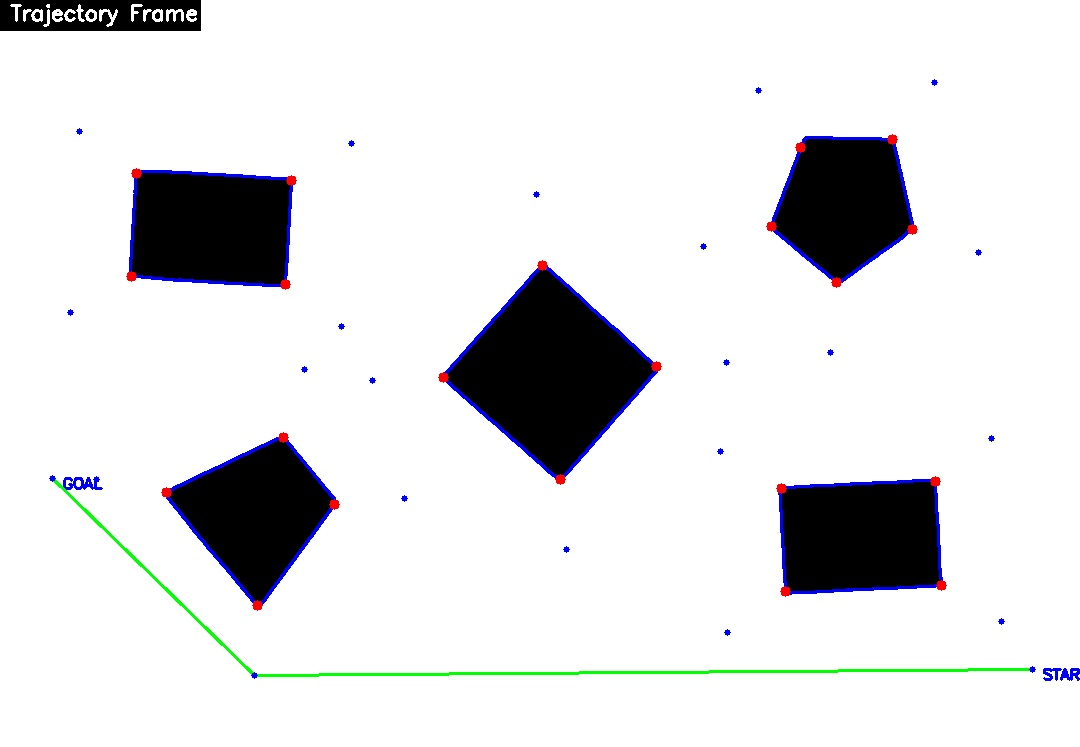

In [13]:
# Display variables
obstacles_img = None
trajectory_frame = None

# Positions variables
thymio_pos = None
goal_pos = None
trajectory_pos = None
obstacles_pos = None

# Flags variables
found_thymio = False
found_goal = False
found_trajectory = False

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    
    input("Press Enter to calculate the perspective vision...")
    
    # Get the perspective parameters for processing frame and return the scale factor for pixels to mm conversion
    vision.get_perspective_parameters(WORLD_MAP)
    
    # Display the original and processed frames
    original_frame, process_frame = vision.get_frame()
    utils.display_frames(original_frame, process_frame)
    
    input("Press Enter to get the obstacles position...")
    
    vision.flush()
    # Get the obstacles position
    _, process_frame = vision.get_frame()
    obstacles_pos, obstacles_img = vision.get_obstacles_position(process_frame)
    
    input("Press Enter when thymio and goal position have been placed on the map...")
    
    vision.flush()
    # Get the goal position and thymio position
    while not found_thymio:
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        time.sleep(DT)
    
    print("Thymio detected!")
    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
    
    while not found_goal:
        _, process_frame = vision.get_frame()
        frame, goal_pos, found_goal = vision.get_goal_position(process_frame)
        time.sleep(DT)
    print("Goal detected!")
    print(f"Goal position [mm]: {np.round(goal_pos, 1)}")
    
    utils.display_frames(None, frame, None)
    
    input("Press Enter to get the trajectory from thymio to goal position...")
    
    vision.flush()
    # Get the trajectory from thymio to goal position
    while not found_trajectory:
        _, frame = vision.get_frame()
        trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                       THYMIO_WIDTH, vision.scale_factor)    
        time.sleep(DT)
         
    # Initialize the EKF
    ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0])) # x, y, theta, v, omega
    ekf.set_mode(covered=False) # Set the mode to uncovered
    
    utils.display_frames(None, frame, trajectory_frame)
    
    input("Press Enter to get overall information...")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
    
except KeyboardInterrupt:
    print("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.disconnect_webcam()
    utils.print_status(obstacles_pos, thymio_pos, goal_pos, trajectory_pos)
    utils.display_frames(None, None, trajectory_frame)
    

### Main Loop

User interrupted the kernel. Shutting down the motors, closing the webcam...
Webcam disconnected correctly.
Finished at time [s]: 12.4
Camera coverage [%]: 16.129032258064516


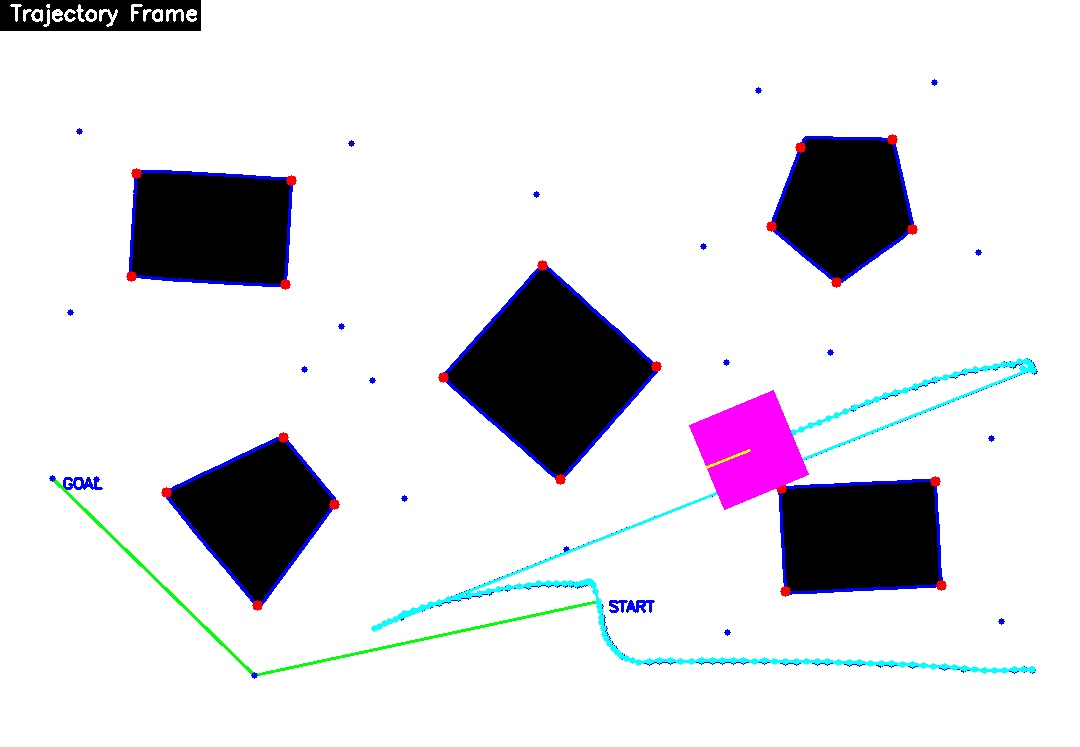

In [14]:
# Display variables
current_frame = None

# Positions variables
thymio_old_pos = thymio_pos
position_measured_history = []
filtered_position_history = [] 

# Flags variables
goal_reached = False

# Control variables
i = 0
covered = 0
left_speed = 0
right_speed = 0

# Initialize video writer
video_writer = None

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
        
    input("Press Enter to start the navigation...")
    
    while not goal_reached:
        i += 1
        
        # Camera Measurement
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        
        # Odometry Measurement
        left_measured_speed, right_measured_speed = get_speed()
        
        # EKF Prediction step with control inputs
        control_input = np.array([left_speed / SPEED_TO_MM_S, right_speed / SPEED_TO_MM_S])  
        ekf.predict(control_input)
        
        # Get current filtered state
        current_state, _ = ekf.get_state_and_covariance()

        if found_thymio:
            position_measured_history.append(thymio_pos[:2])
            
            # Use camera position and odometry for measurement
            measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
            if utils.distance(current_state[:2], thymio_old_pos[:2]) > KIDNAP_THRESHOLD:
                found_trajectory = False
                found_thymio = False
                motor_stop()
                
                input("Kidnapped! Press Enter when Thymio has been placed elsewhere...")
                vision.flush()
                while not found_trajectory:
                    while not found_thymio:
                        _, process_frame = vision.get_frame()
                        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
                        time.sleep(DT)
                        
                    print("Thymio detected!")
                    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
                    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
                    
                    trajectory_frame = np.zeros_like(trajectory_frame)
                    trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                                   THYMIO_WIDTH, vision.scale_factor)
                    current_frame = trajectory_frame.copy()
                    current_frame = utils.draw_trajectory(current_frame, position_measured_history, 
                                                          vision.scale_factor, color=(255, 0, 0))

                    current_frame = utils.draw_trajectory(current_frame, filtered_position_history, 
                                                        vision.scale_factor, color=(255, 255, 0))
                    
                    current_frame = utils.draw_robot(current_frame, thymio_pos, THYMIO_WIDTH, 
                                                     THYMIO_LENGTH, vision.scale_factor)
                    time.sleep(DT)
                    
                current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                                 filtered_position_history, current_state,
                                                                 THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
                    
                # Reinitialize the EKF after kidnapping
                ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0]))
                
                # Reset current checkpoint
                local_nav.current_checkpoint = 0
                
                video_writer = utils.record_frames(None, process_frame, current_frame, video_writer, DT)
            
                input("Press Enter to validate the new trajectory...")
                
        else: 
            covered += 1
            # Use filtered position when camera cannot see robot
            measurement = np.array([current_state[0], current_state[1], current_state[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
        thymio_old_pos = current_state[:3]
        
        # Update EKF with appropriate mode
        ekf.set_mode(covered=(not found_thymio))
        ekf.update(measurement)
        
        # Use filtered state for navigation
        filtered_state, _ = ekf.get_state_and_covariance()
        filtered_position_history.append(filtered_state[:2])
        
        command, goal_reached = local_nav.get_command(trajectory_pos, filtered_state[:3], sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacles'):
            left_speed = command['left_speed']
            right_speed = command['right_speed']
            set_speed(left_speed, right_speed)
            
        elif command['action'] == 'recompute_trajectory': # Recompute trajectory after obstacle avoidance
            found_trajectory = False
            while not found_trajectory:
                _, process_frame = vision.get_frame()
                trajectory_frame = np.zeros_like(trajectory_frame)
                trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, filtered_state[:3], goal_pos, obstacles_pos, 
                                                                                               THYMIO_WIDTH, vision.scale_factor)
                time.sleep(DT)
            current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                             filtered_position_history, current_state,
                                                             THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
            local_nav.current_checkpoint = 0
        else:
            motor_stop()
        
        current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                         filtered_position_history, current_state,
                                                         THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
        
        video_writer = utils.record_frames(None, process_frame, current_frame, video_writer)
        time.sleep(DT)
        
except Exception as e:
    print(f"An error occurred: {str(e)}")
    
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors, closing the webcam...")
finally:
    # Release resources
    vision.disconnect_webcam()
    if video_writer:
        video_writer.release()
    motor_stop()
    print("Finished at time [s]:", i * DT)
    print("Camera coverage [%]:", covered/i * 100)
    utils.display_frames(None, None, current_frame)
   

In [ ]:

await tdmclient.notebook.stop()
print("Successfully disconnected to Thymio.")

Successfully connected to Thymio.


In [29]:
from IPython.display import clear_output

# Rotation parameters
ANGLE_TOLERANCE = 5 # degrees
KP_ROTATION = 90
MAX_ROTATION_SPEED = 150

# Translation parameters
DISTANCE_TOLERANCE = 50 # mm
KP_TRANSLATION = 0.7 
MIN_TRANSLATION_SPEED = 100
MAX_TRANSLATION_SPEED = 200

# Obstacle avoidance parameters
OBSTACLES_MAX_ITER = 1
OBSTACLES_SPEED = 100
SCALE_SENSOR = 200
WEIGHT_LEFT = [ 5,  8, -10,  -8, -5]
WEIGHT_RIGHT = [-5, -8, -10, 8,  5]


In [40]:
def avoid_obstacles(sensor_data):
    sensor_data = sensor_data[:5]
    print(sensor_data)
    left_speed = 0
    right_speed = 0

    # Updates speed based on sensor data and their corresponding weights
    for i in range(len(sensor_data)):
        left_speed = left_speed + sensor_data[i] * WEIGHT_LEFT[i] / SCALE_SENSOR
        right_speed = right_speed + sensor_data[i] * WEIGHT_RIGHT[i] / SCALE_SENSOR

    command = {
            'action': 'avoid_obstacles',
            'left_speed': int(left_speed + OBSTACLES_SPEED),
            'right_speed': int(right_speed + OBSTACLES_SPEED)
        }
    return command, False

In [41]:
try:
    while 1:
        command, _ = avoid_obstacles(sensor_data())
        print(command)
        v_l = command['left_speed']
        v_r = command['right_speed']
        set_speed(v_l, v_r)
        clear_output(wait=True)
        time.sleep(0.2)
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors...")
finally:
    motor_stop()
    print("Motors stopped.")

User interrupted the kernel. Shutting down the motors...
Motors stopped.
